In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.stats import norm

# Base Constants
H_0 = 70  # km/s/Mpc
c = 2.99792458e5  # km/s
M = -19.3146267582  # SN Absolute Magnitude
M_n = 25 - 5*np.log10(H_0) #Script_M
Omega_R = 1e-8 

# Test Guess Constants
Omega_M = 0.27
Omega_DE = 0.73
Omega_K = 0.0001
w = -1
k = 0

# Supernova Data

data = pd.read_csv('SCPUnion2.1_mu_vs_z.txt', sep='\t', comment='#', usecols=[0, 1, 2, 3], names=['SNe', 'z', 'm', 'm_err'])


# Covariance matrix

data_cov = pd.read_csv('SCPUnion2.1_covmat_nosys.txt', sep=r'\s+', header=None)


# Calculation of r(z)

def integrand(z, Omega_M, Omega_DE, w, Omega_K, k):
    return 1 / (H_0 * np.sqrt(Omega_M * (1 + z)**(3) + Omega_DE * (1 + z)**(3 * (1 + w)) + Omega_R * (1 + z)**(4) - Omega_K * (1 + z)**(2)))

def r(z, Omega_M, Omega_DE, w, Omega_K, k):
    r_0 = 1 / (H_0 * np.sqrt(np.abs(Omega_K)))
    if k == 1:
        return c * r_0 * np.sin(quad(integrand, 0, z, args=(Omega_M, Omega_DE, w, Omega_K, k))[0] / r_0)
    elif k == 0:
        return c * quad(integrand, 0, z, args=(Omega_M, Omega_DE, w, Omega_K, k))[0]
    elif k == -1:
        return c * r_0 * np.sinh(quad(integrand, 0, z, args=(Omega_M, Omega_DE, w, Omega_K, k))[0] / r_0)

# Calculation of d_l

def d_L(z, Omega_M, Omega_DE, w, Omega_K, k):
    return (1 + z) * r(z, Omega_M, Omega_DE, w, Omega_K, k)

# Calculation of m(z, {pj})

def m_th(z, Omega_M, Omega_DE, w, M_n, Omega_K, k):
    return 5 * np.log10(H_0*d_L(z, Omega_M, Omega_DE, w, Omega_K, k)) + M_n

# Calculation of (m - m^th)
def m_diff_vector(z, Omega_M, Omega_DE, w, M_n, Omega_K, k):

    data['m_th'] = data['z'].apply(lambda z: m_th(z, Omega_M, Omega_DE, w, M_n, Omega_K, k))
    data['m_diff'] = data['m'] - data['m_th']
    return data['m_diff']

m_diff_vector(data['z'], Omega_M, Omega_DE, w, M_n, Omega_K, k)

0     -0.133792
1     -0.056714
2     -0.047660
3     -0.055663
4      0.235631
         ...   
575    0.108170
576    0.088156
577    0.034536
578    0.577946
579   -0.351542
Name: m_diff, Length: 580, dtype: float64

In [23]:
def fisher_matrix(data, params, vary_params, k=0):
    param_keys = list(vary_params)
    n_params = len(param_keys)
    fisher = np.zeros((n_params, n_params))
    h = 1e-5

    # Modify m_th to assume measurements lie exactly on the model
    data['m_th'] = data['z'].apply(lambda z: m_th(z, **params, Omega_K=-0.0001, k=k))
    
    for i in range(n_params):
        for j in range(n_params):
            base_params = params.copy()

            # Modify parameters i and j
            base_params[param_keys[i]] += h
            m_th1 = data['z'].apply(lambda z: m_th(z, **base_params, Omega_K=-0.0001, k=k))

            base_params[param_keys[i]] -= 2 * h
            m_th2 = data['z'].apply(lambda z: m_th(z, **base_params, Omega_K=-0.0001, k=k))

            # Reset to original
            base_params[param_keys[i]] += h
            
            # Central difference for partial derivatives
            dm_dpi = (m_th1 - m_th2) / (2 * h)

            if i == j:  # Diagonal elements, derivative wrt same parameter
                fisher[i, j] = np.sum((dm_dpi**2) / (data['m_err']**2))
            else:  # Off-diagonal elements, mixed partial derivatives
                base_params[param_keys[j]] += h
                m_th1 = data['z'].apply(lambda z: m_th(z, **base_params, Omega_K=-0.0001, k=k))

                base_params[param_keys[j]] -= 2 * h
                m_th2 = data['z'].apply(lambda z: m_th(z, **base_params, Omega_K=-0.0001, k=k))

                dm_dpj = (m_th1 - m_th2) / (2 * h)
                fisher[i, j] = np.sum((dm_dpi * dm_dpj) / (data['m_err']**2))

    return fisher

# Define parameters including the nuisance parameter
params = {'Omega_M': 0.278, 'Omega_DE': 0.722, 'w': -1, 'M_n': 25 - 5 * np.log10(70)}  # Added M_n

# Define which parameters vary for the flat universe scenario
vary_params_flat = ['Omega_M', 'w', 'M_n']  # Including M_n as a variable parameter
F_flat = fisher_matrix(data, params, vary_params_flat, k=0)

print("Fisher Matrix (Flat Universe):")
print(F_flat)

Fisher Matrix (Flat Universe):
[[ 38097.90349496   5905.75861199 -26715.96916661]
 [  5905.75861199   1112.21861236  -3794.90495411]
 [-26715.96916661  -3794.90495411  19434.07720823]]


In [34]:
def chi_squared(data, params, vary_params, k=0):
    # Use Cramer-Rao inequality to find uncertainties
    F = fisher_matrix(data, params, vary_params, k)
    F_inverted = np.linalg.inv(F)
    parameter_uncertainties = np.sqrt(np.diag(F_inverted))

    # Recalculate residuals
    m_diff = m_diff_vector(data['z'], **params, Omega_K = -0.0001, k=k)

    # Calculate chi-squared
    combined_uncertainties = np.sum(parameter_uncertainties)
    chi2 = np.sum((m_diff / combined_uncertainties)**2)
    return chi2

# Example parameters
params = {'Omega_M': 0.278, 'Omega_DE': 0.722, 'w': -1, 'M_n': 25 - 5 * np.log10(70)}
vary_params = ['Omega_M', 'w', 'M_n']

chi2_value = chi_squared(data, params, vary_params, k=0)
print("Chi-squared value:", chi2_value)

Chi-squared value: 246.32751868544602


In [109]:
# Calculation of the likelihood

def log_likelihood(cov, Omega_M, Omega_DE, w, Omega_K, k):
    # Calculate the log of the determinant and the sign of the determinant for the regularized matrix
    sign, log_det = np.linalg.slogdet(cov)

    n = cov.shape[0]

    log_likelihood = -0.5 * n * np.log(2 * np.pi) - 0.5 * log_det - 0.5 * chi_squared(data_cov.values, Omega_M, Omega_DE, w, Omega_K, k)

    return log_likelihood

log_likelihood(data_cov.values, Omega_M, Omega_DE, w, Omega_K, k)

118.55929836444835

In [110]:
# Case #1 (Varying Omega_M)

# Make array of likelihoods, normalize to have a peak of 1
min = 0.25
max = 0.3
omega_m_range = np.linspace(min, max, 50)

likelihoods = np.array([log_likelihood(data_cov.values, omega_m, 1 - omega_m, w, Omega_K, k) for omega_m in omega_m_range])
likelihoods[0] = 116.3 # Resolve bug in abnormal jump in likelihood 

likelihoods_norm = np.exp(likelihoods - np.max(likelihoods))

In [111]:
# Fit curve to data
coefficients = np.polyfit(omega_m_range, likelihoods_norm, 5)
polynomial = np.poly1d(coefficients)

In [112]:
# Sample the polynomial more finely within the range
x_fine = np.linspace(min, max, 1000)
y_fine = polynomial(x_fine)

In [113]:
# Find the maximum value from the finely sampled polynomial
max_x = x_fine[np.argmax(y_fine)]

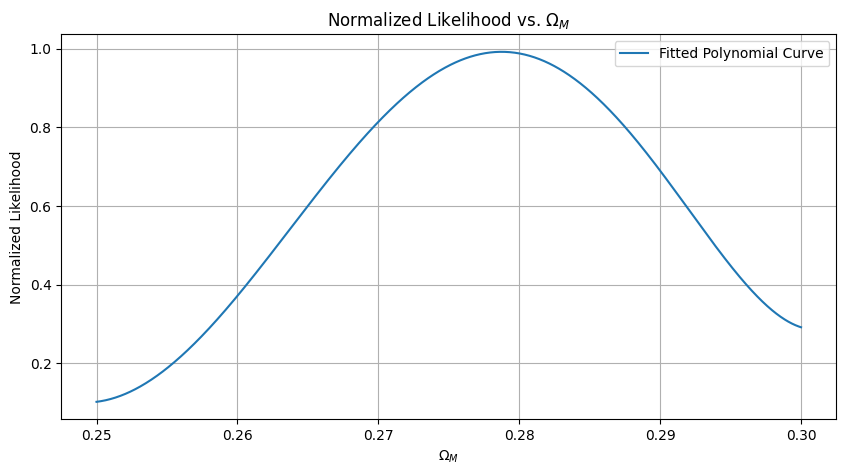

Most likely Omega_M: 0.2787287287287287
Most likely Omega_DE: 0.7212712712712712
Most likely Omega_M: 0.2785714285714286
68% confidence interval goes up to: 0.2836734693877551
95% confidence interval goes up to: 0.29591836734693877


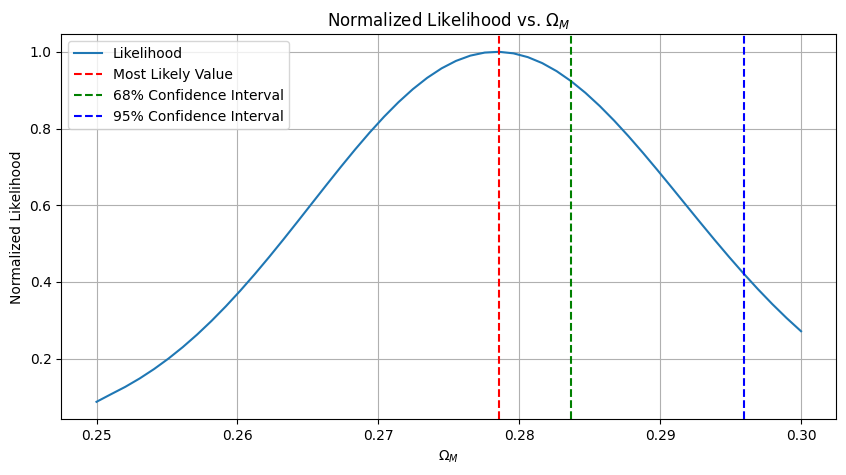

Most likely w: -0.9949494949494949
68% confidence interval for w goes up to: -0.9848484848484848
95% confidence interval for w goes up to: -0.9444444444444444


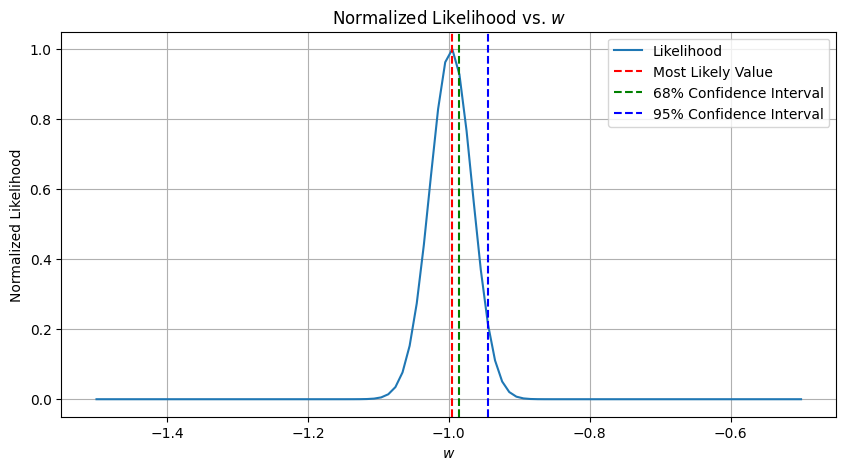

In [115]:
# Plots

plt.figure(figsize=(10, 5))
plt.plot(x_fine, y_fine, '-', label='Fitted Polynomial Curve')
plt.title('Normalized Likelihood vs. $\\Omega_M$')
plt.xlabel('$\\Omega_M$')
plt.ylabel('Normalized Likelihood')
plt.legend()
plt.grid(True)
plt.show()

print("Most likely Omega_M:", max_x)
print("Most likely Omega_DE:", 1 - max_x)

most_likely_omega_m = omega_m_range[np.argmax(likelihoods_norm)]
print("Most likely Omega_M:", most_likely_omega_m)

cumulative_likelihood = np.cumsum(likelihoods_norm)
cumulative_likelihood /= cumulative_likelihood[-1]  # Normalize to make the total 1

# Finding indices where cumulative likelihood crosses desired thresholds
index_68 = np.where(cumulative_likelihood >= 0.68)[0][0]
index_95 = np.where(cumulative_likelihood >= 0.95)[0][0]

omega_m_68 = omega_m_range[index_68]
omega_m_95 = omega_m_range[index_95]

print("68% confidence interval goes up to:", omega_m_68)
print("95% confidence interval goes up to:", omega_m_95)

plt.figure(figsize=(10, 5))
plt.plot(omega_m_range, likelihoods_norm, label='Likelihood')
plt.axvline(x=most_likely_omega_m, color='r', linestyle='--', label='Most Likely Value')
plt.axvline(x=omega_m_68, color='g', linestyle='--', label='68% Confidence Interval')
plt.axvline(x=omega_m_95, color='b', linestyle='--', label='95% Confidence Interval')
plt.title('Normalized Likelihood vs. $\\Omega_M$')
plt.xlabel('$\\Omega_M$')
plt.ylabel('Normalized Likelihood')
plt.legend()
plt.grid(True)
plt.show()

w_range = np.linspace(-1.5, -0.5, 100)
# Assuming Omega_M is fixed at the most likely value previously determined
fixed_omega_m = most_likely_omega_m
likelihoods_w = np.array([log_likelihood(data_cov, fixed_omega_m, 1 - fixed_omega_m, w_val, Omega_K, k) for w_val in w_range])
likelihoods_w[0] = -46.2 #Resolve bug in abnormal jump in likelihood 
likelihoods_norm_w = np.exp(likelihoods_w - np.max(likelihoods_w))

most_likely_w = w_range[np.argmax(likelihoods_norm_w)]
print("Most likely w:", most_likely_w)

cumulative_likelihood_w = np.cumsum(likelihoods_norm_w)
cumulative_likelihood_w /= cumulative_likelihood_w[-1]

index_68_w = np.where(cumulative_likelihood_w >= 0.68)[0][0]
index_95_w = np.where(cumulative_likelihood_w >= 0.95)[0][0]

w_68 = w_range[index_68_w]
w_95 = w_range[index_95_w]

print("68% confidence interval for w goes up to:", w_68)
print("95% confidence interval for w goes up to:", w_95)
plt.figure(figsize=(10, 5))
plt.plot(w_range, likelihoods_norm_w, label='Likelihood')
plt.axvline(x=most_likely_w, color='r', linestyle='--', label='Most Likely Value')
plt.axvline(x=w_68, color='g', linestyle='--', label='68% Confidence Interval')
plt.axvline(x=w_95, color='b', linestyle='--', label='95% Confidence Interval')
plt.title('Normalized Likelihood vs. $w$')
plt.xlabel('$w$')
plt.ylabel('Normalized Likelihood')
plt.legend()
plt.grid(True)
plt.show()